In [31]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline

# Load Data

In [2]:
def loadData(fileName, path='../data/'):
    xlsx = pd.read_excel(path+fileName)
    
    return xlsx

In [10]:
xlsx = loadData('pccstorgb.xlsx')

In [11]:
print(xlsx.head())
print()
print(xlsx.tail())
print()
print(xlsx.shape)

     R    G    B    H     S     V           tone
0  189  162  162  0.0  14.3  74.1  light_grayish
1  111   88   88  0.0  20.7  43.5        Grayish
2  233  184  184  0.0  21.0  91.4           Pale
3   61   47   47  0.0  23.0  23.9   dark_grayish
4  158   83   83  0.0  47.4  62.0           dull

        R    G    B    H    S    V        tone
1692  252  252  252  0.0  0.0  0.0  Achromatic
1693  253  253  253  0.0  0.0  0.0  Achromatic
1694  254  254  254  0.0  0.0  0.0  Achromatic
1695  255  255  255  0.0  0.0  0.0  Achromatic
1696  256  256  256  0.0  0.0  0.0  Achromatic

(1697, 7)


In [5]:
print(type(xlsx))

<class 'pandas.core.frame.DataFrame'>


# Data Cleaning

In [12]:
def dataCleaning(xlsx):
    rgb = xlsx[{'R', 'G', 'B'}].to_numpy()
    hsv = xlsx[{'H', 'S', 'V'}].to_numpy()
    rgbhsv = xlsx[{'R', 'G', 'B', 'H', 'S', 'V'}].to_numpy()
    tone = xlsx['tone'].to_numpy()

    #toneType = np.unique(tone)
    toneType = np.array(['Vivid', 'bright', 'strong', 'deep', 'Light', 'Soft', 'dull', 'Dark', 'Pale', 'light_grayish', 'Grayish', 'dark_grayish', 'Achromatic'])

    y = [np.where(toneType == t)[0][0] for t in tone]

    return rgb, hsv, rgbhsv, tone, toneType, y

In [7]:
[rgb, hsv, rgbhsv, tone, toneType, y] = dataCleaning(xlsx)

In [8]:
print(rgb[:5])
print(hsv[:5])
print(rgbhsv[:5])
print(tone[:5])
print(toneType)
print(y[:5])

[[162 162 189]
 [ 88  88 111]
 [184 184 233]
 [ 47  47  61]
 [ 83  83 158]]
[[74.1 14.3  0. ]
 [43.5 20.7  0. ]
 [91.4 21.   0. ]
 [23.9 23.   0. ]
 [62.  47.4  0. ]]
[[189.   74.1 162.  162.    0.   14.3]
 [111.   43.5  88.   88.    0.   20.7]
 [233.   91.4 184.  184.    0.   21. ]
 [ 61.   23.9  47.   47.    0.   23. ]
 [158.   62.   83.   83.    0.   47.4]]
['light_grayish' 'Grayish' 'Pale' 'dark_grayish' 'dull']
['Vivid' 'bright' 'strong' 'deep' 'Light' 'Soft' 'dull' 'Dark' 'Pale'
 'light_grayish' 'Grayish' 'dark_grayish']
[9, 10, 8, 11, 6]


# Data Splitting

In [13]:
def _adjustTTVSize(train_size, test_size, validate_size):
    s = max(train_size,0) + max(test_size,0) + max(validate_size,0)
    if s == 0:
        return 0.8, 0.2, 0
    
    if s > 1:
        train_size = train_size / s
        test_size = test_size / s
        validate_size = validate_size / s
        s = 1
    
    if train_size >= 0 and test_size >= 0 and validate_size >= 0:
        return train_size, test_size, validate_size
    
    if train_size >= 0 and test_size < 0 and validate_size < 0:
        return train_size, 1-train_size, 0
    
    if train_size < 0 and test_size >= 0 and validate_size < 0:
        return 1-test_size, test_size, 0
    
    if train_size < 0 and test_size < 0 and validate_size > 0:
        return (1-validate_size)*0.8, (1-validate_size)*0.2, validate_size
    
    if train_size < 0: train_size = 1-s
    if test_size < 0: test_size = 1-s
    if validate_size < 0: validate_size = 1-s
    
    return train_size, test_size, validate_size

In [14]:
'''
*** parameters ***
data : [data_list1, ...]
train_size, test_size, validate_size : 0~1, sum=1 / default=0.8,0.2,0

*** returns ***
split : [[train_data_list1, test_data_list1, validate_data_list1], ...]
'''
def dataSplitting(data, train_size=-1, test_size=-1, validate_size=-1):
    [train_size, test_size, validate_size] = _adjustTTVSize(train_size, test_size, validate_size)
    
    n = len(data[0])
    randomOrder = list(range(n))
    random.shuffle(randomOrder)
    
    split = []
    for d in data:
        train = []
        test = []
        validate = []
        
        for i in range(n):
            if i < train_size*n:
                train.append(d[randomOrder[i]])
            elif i < (train_size + test_size)*n:
                test.append(d[randomOrder[i]])
            else:
                validate.append(d[randomOrder[i]])
        
        split.append([np.array(train), np.array(test), np.array(validate)])
    
    return split

In [30]:
[[rgb_train, rgb_test, rgb_validate],
 [hsv_train, hsv_test, hsv_validate],
 [rgbhsv_train, rgbhsv_test, rgbhsv_validate],
  [y_train, y_test, y_validate]] = dataSplitting([rgb, hsv, rgbhsv, y], 0.6, 0.2, 0.2)

In [31]:
print(rgb_train[:5], y_train[:5])
print(rgb_test[:5], y_test[:5])
print(rgb_validate[:5], y_validate[:5])

[[160  47  27]
 [208 115 128]
 [169  72 105]
 [ 45  77  43]
 [235 170 193]] [8 4 9 0 3]
[[193 156 181]
 [111  33  63]
 [108  27  90]
 [249  71 127]
 [181 170 161]] [10  0  0  6 10]
[[159  52  27]
 [216   0 193]
 [  0 110  85]
 [ 38   0 119]
 [235   0 125]] [8 5 8 8 5]


# Learn

In [22]:
'''
*** parameters ***
verbose
- 0 : silent
- 1 : progress bar,
- 2 : one line per epoch
'''
def modelLearning(X, y, epochs=20, input_size=3, verbose=0):

    model = keras.Sequential([
        keras.layers.Dense(1024, activation='gelu', input_shape=[input_size]),
        keras.layers.Dense(1024, activation='gelu'),
        keras.layers.Dense(13, activation='softmax')
    ])

    model.compile(optimizer='adam',
                 loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'])

    hist = model.fit(X, y, epochs=epochs, verbose=verbose)
    
    return model

In [7]:
# model = modelLearning(rgb_train, y_train, 20, 3, 1)

In [36]:
rgb_model = modelLearning(rgb_train, y_train, epochs=50, input_size=3, verbose=0)
hsv_model = modelLearning(hsv_train, y_train, epochs=50, input_size=3, verbose=0)
rgbhsv_model = modelLearning(rgbhsv_train, y_train, epochs=50, input_size=6, verbose=0)

# Validation

In [16]:
'''
*** returns ***
results : [loss, acc]
'''
def modelValidation(model, X, y):
    results = model.evaluate(X, y)
    print("loss, acc:", results)
    
    return results

In [81]:
rgb_lossacc = modelValidation(rgb_model, rgb_validate, y_validate)
hsv_lossacc = modelValidation(hsv_model, hsv_validate, y_validate)
rgbhsv_lossacc = modelValidation(rgbhsv_model, rgbhsv_validate, y_validate)

9/9 [==============================] - 0s 2ms/step - loss: 0.0997 - accuracy: 0.9722
loss, acc: [0.0997205525636673, 0.9722222089767456]
9/9 [==============================] - 0s 2ms/step - loss: 0.0947 - accuracy: 0.9444
loss, acc: [0.09466405212879181, 0.9444444179534912]
9/9 [==============================] - 0s 2ms/step - loss: 0.4427 - accuracy: 0.8785
loss, acc: [0.4427071511745453, 0.8784722089767456]


# Prediction

In [17]:
'''
*** parameter ***
col : [[color info1], ...]
    color info : [r,g,b] or [h,s,v] or [r,g,b,h,s,v]

*** returns ***
results : [prediction1, ...]
    By adding toneType, you can obtain ton type predictions, or you can obtain numerical predictions
'''
def predictionColor(model, col, toneType=None):
    predictions = model.predict(col)
    
    if toneType is None:
        results = [np.argmax(prediction) for prediction in predictions]
    else:
        results = [toneType[np.argmax(prediction)] for prediction in predictions]
    
    return results

In [18]:
def predictionPlus(rgb_model, hsv_model, rgbhsv_model, rgb=None, hsv=None, rgbhsv=None, toneType=None, p_rgb=1, p_hsv=1, p_rgbhsv=1):
    if rgb is None:
        rgb = np.array([c[:3] for c in rgbhsv])
    if hsv is None:
        hsv = np.array([c[3:] for c in rgbhsv])
    if rgbhsv is None:
        rgbhsv = np.array([np.concatenate((rgb[i],hsv[i])) for i in range(len(rgb))])
    
    rgb_predictions = rgb_model.predict(rgb)
    hsv_predictions = hsv_model.predict(hsv)
    rgbhsv_predictions = rgbhsv_model.predict(rgbhsv)
    
    predictions = [rgb_predictions[i]*p_rgb + hsv_predictions[i]*p_hsv + rgbhsv_predictions[i]*p_rgbhsv for i in range(len(rgb))]
    
    if toneType is None:
        results = [np.argmax(prediction) for prediction in predictions]
    else:
        results = [toneType[np.argmax(prediction)] for prediction in predictions]
        
    return results

In [94]:
rgb_predictions = predictionColor(rgb_model, rgb_test)
hsv_predictions = predictionColor(hsv_model, hsv_test)
rgbhsv_predictions = predictionColor(rgbhsv_model, rgbhsv_test)
plus_predictions = predictionPlus(rgb_model, hsv_model, rgbhsv_model, rgb=rgb_test, hsv=hsv_test, p_rgb=rgb_lossacc[1], p_hsv=hsv_lossacc[1], p_rgbhsv=rgbhsv_lossacc[1])
print(rgb_predictions[:20])
print(hsv_predictions[:20])
print(rgbhsv_predictions[:20])
print(plus_predictions[:20])
print(y_test[:20])

[1, 7, 2, 0, 1, 10, 3, 3, 0, 5, 9, 1, 2, 8, 7, 3, 5, 6, 8, 5]
[1, 7, 2, 0, 1, 10, 3, 3, 0, 5, 9, 1, 2, 8, 7, 3, 5, 6, 8, 11]
[1, 0, 4, 0, 1, 10, 10, 10, 0, 5, 9, 1, 2, 8, 7, 3, 11, 6, 8, 11]
[1, 7, 2, 0, 1, 10, 3, 3, 0, 5, 9, 1, 2, 8, 7, 3, 5, 6, 8, 5]
[ 1  7  2  0  1 10  3  3  0  5  9  1  2  8  7  3 11  6  8  5]


# Compare Results

In [19]:
def compareResults(x, y):
    N = len(x)
    correct = 0
    wrong = 0
    
    for i in range(N):
        if x[i] == y[i]:
            correct = correct+1
        else:
            wrong = wrong+1
    
    return correct, wrong, correct/N

In [83]:
rgb_cmp_results = compareResults(rgb_predictions, y_test)
hsv_cmp_results = compareResults(hsv_predictions, y_test)
rgbhsv_cmp_results = compareResults(rgbhsv_predictions, y_test)
plus_cmp_results = compareResults(plus_predictions, y_test)

In [85]:
print("RGB:", rgb_cmp_results[2])
print("HSV:", hsv_cmp_results[2])
print("RGBHSV:", rgbhsv_cmp_results[2])
print("Plus:", plus_cmp_results[2])

RGB: 0.9548611111111112
HSV: 0.9305555555555556
RGBHSV: 0.8715277777777778
Plus: 0.9513888888888888


# Save Model

In [20]:
def saveModel(model, modelName, path='../model/'):
    model_path = path + modelName + '.h5'
    tflite_path = path + modelName + '.tflite'

    # save model
    model.save(model_path)
    
    # convert model to tflite
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    #converter = tf.lite.TFLiteConverter.from_keras_model_file(model_path)
    #converter = tf.compat.v1.lite.TFLiteConverter.from_keras_model_file(model_path)
    converter.target_spec.supported_ops = [
      tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
      tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
    ]
    tflite_model = converter.convert()

    with open(tflite_path, 'wb') as f:
        f.write(tflite_model) 

In [29]:
saveModel(rgb_model, 'rgb')
saveModel(hsv_model, 'hsv')
saveModel(rgbhsv_model, 'rgbhsv')

INFO:tensorflow:Assets written to: C:\Users\SAMSUNG\AppData\Local\Temp\tmpnwgcx4l8\assets


INFO:tensorflow:Assets written to: C:\Users\SAMSUNG\AppData\Local\Temp\tmpnwgcx4l8\assets


INFO:tensorflow:Assets written to: C:\Users\SAMSUNG\AppData\Local\Temp\tmp1uxk7kcf\assets


INFO:tensorflow:Assets written to: C:\Users\SAMSUNG\AppData\Local\Temp\tmp1uxk7kcf\assets


INFO:tensorflow:Assets written to: C:\Users\SAMSUNG\AppData\Local\Temp\tmpiddbcepv\assets


INFO:tensorflow:Assets written to: C:\Users\SAMSUNG\AppData\Local\Temp\tmpiddbcepv\assets


In [ ]:
model = tf.keras.models.load_model("Path")
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Final

In [23]:
# Load Data
xlsx = loadData('pccstorgb.xlsx')
print("Complete to load data!\n")

# Data Cleaning
[rgb, hsv, rgbhsv, tone, toneType, y] = dataCleaning(xlsx)
print("Complete data cleaning!\n")

#Data Splitting
[[rgb_train, rgb_test, rgb_validate],
 [hsv_train, hsv_test, hsv_validate],
 [rgbhsv_train, rgbhsv_test, rgbhsv_validate],
  [y_train, y_test, y_validate]] = dataSplitting([rgb, hsv, rgbhsv, y], 0.6, 0.2, 0.2)
print("Complete data Splitting!\n")

# Learn
print("***** Learn *****")
rgb_model = modelLearning(rgb_train, y_train, epochs=50, input_size=3, verbose=0)
print("Complete RGB")
hsv_model = modelLearning(hsv_train, y_train, epochs=50, input_size=3, verbose=0)
print("Complete HSV")
rgbhsv_model = modelLearning(rgbhsv_train, y_train, epochs=50, input_size=6, verbose=0)
print("Complete RGB & HSV\n")
# Measure loss, accuracy
print("***** Measure loss and accuracy *****")
print("RGB")
rgb_lossacc = modelValidation(rgb_model, rgb_train, y_train)
print("HSV")
hsv_lossacc = modelValidation(hsv_model, hsv_train, y_train)
print("RGB & HSV")
rgbhsv_lossacc = modelValidation(rgbhsv_model, rgbhsv_train, y_train)
print()

# Validation
print("***** Validation *****")
print("RGB")
rgb_results = modelValidation(rgb_model, rgb_validate, y_validate)
print("HSV")
hsv_results = modelValidation(hsv_model, hsv_validate, y_validate)
print("RGB & HSV")
rgbhsv_results = modelValidation(rgbhsv_model, rgbhsv_validate, y_validate)
print()

# Prediction(validation data)
print("***** Predict(validation data) *****")
rgb_predictions = predictionColor(rgb_model, rgb_test)
hsv_predictions = predictionColor(hsv_model, hsv_test)
rgbhsv_predictions = predictionColor(rgbhsv_model, rgbhsv_test)
plus_predictions = predictionPlus(rgb_model, hsv_model, rgbhsv_model, rgb=rgb_test, hsv=hsv_test, p_rgb=rgb_lossacc[1], p_hsv=hsv_lossacc[1], p_rgbhsv=rgbhsv_lossacc[1])
print("RGB:", rgb_predictions[:20])
print("HSV:", hsv_predictions[:20])
print("RGB&HSV:", rgbhsv_predictions[:20])
print("Plus:", plus_predictions[:20])
print("y:", y_test[:20])
print()

# Compare Results
print("***** Compare Results *****")
rgb_cmp_results = compareResults(rgb_predictions, y_test)
hsv_cmp_results = compareResults(hsv_predictions, y_test)
rgbhsv_cmp_results = compareResults(rgbhsv_predictions, y_test)
plus_cmp_results = compareResults(plus_predictions, y_test)
print("RGB:", rgb_cmp_results[2])
print("HSV:", hsv_cmp_results[2])
print("RGBHSV:", rgbhsv_cmp_results[2])
print("Plus:", plus_cmp_results[2])
print()

# Save Model
print("***** Save Models *****")
saveModel(rgb_model, 'rgb')
print("Complete RGB")
saveModel(hsv_model, 'hsv')
print("Complete HSV")
saveModel(rgbhsv_model, 'rgbhsv')
print("Complete RGB & HSV")

Complete to load data!

Complete data cleaning!

Complete data Splitting!

***** Learn *****
Complete RGB
Complete HSV
Complete RGB & HSV

***** Measure loss and accuracy *****
RGB
32/32 [==============================] - 0s 2ms/step - loss: 0.0620 - accuracy: 0.9804
loss, acc: [0.062039125710725784, 0.9803729057312012]
HSV
32/32 [==============================] - 0s 2ms/step - loss: 0.1284 - accuracy: 0.9509
loss, acc: [0.12836582958698273, 0.9509322643280029]
RGB & HSV
32/32 [==============================] - 0s 2ms/step - loss: 0.1277 - accuracy: 0.9450
loss, acc: [0.12765571475028992, 0.9450441598892212]

***** Validation *****
RGB
11/11 [==============================] - 0s 2ms/step - loss: 0.0851 - accuracy: 0.9646
loss, acc: [0.08509667962789536, 0.9646017551422119]
HSV
11/11 [==============================] - 0s 2ms/step - loss: 0.1274 - accuracy: 0.9587
loss, acc: [0.12744124233722687, 0.9587020874023438]
RGB & HSV
11/11 [==============================] - 0s 2ms/step - loss: 0

INFO:tensorflow:Assets written to: C:\Users\SAMSUNG\AppData\Local\Temp\tmpw9t2yjdq\assets


Complete HSV
INFO:tensorflow:Assets written to: C:\Users\SAMSUNG\AppData\Local\Temp\tmp5bh5gl59\assets


INFO:tensorflow:Assets written to: C:\Users\SAMSUNG\AppData\Local\Temp\tmp5bh5gl59\assets


Complete RGB & HSV


In [32]:
print(toneType)

['Vivid' 'bright' 'strong' 'deep' 'Light' 'Soft' 'dull' 'Dark' 'Pale'
 'light_grayish' 'Grayish' 'dark_grayish']


In [24]:
all_color = []

for r in range(256):
    for g in range(256):
        for b in range(256):
            all_color.append([r,g,b])

In [25]:
all_predictions = predictionColor(rgb_model, all_color)

In [26]:
achromatic_color = []
for i in range(len(all_predictions)):
    if all_predictions[i] == 12:
        achromatic_color.append(all_color[i])

In [30]:
print(len(achromatic_color))
print(achromatic_color[:20])

219293
[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 0, 8], [0, 0, 9], [0, 0, 10], [0, 0, 11], [0, 0, 12], [0, 0, 13], [0, 0, 14], [0, 1, 0], [0, 1, 1], [0, 1, 2], [0, 1, 3], [0, 1, 4]]


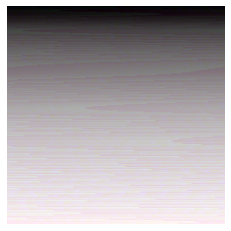

In [55]:
one_px = np.array(achromatic_color[:219024])[np.newaxis, :, :]
one_px = one_px.reshape(468,468,3)

plt.imshow(np.array(one_px))
plt.axis('off')
plt.show()

In [52]:
one_px

array([[[0, 0, 0],
        [0, 0, 1],
        [0, 0, 2],
        [0, 0, 3],
        [0, 0, 4],
        [0, 0, 5],
        [0, 0, 6],
        [0, 0, 7],
        [0, 0, 8],
        [0, 0, 9]]])

In [47]:
one_px

array([[[0, 0, 0],
        [0, 0, 1],
        [0, 0, 2],
        [0, 0, 3],
        [0, 0, 4],
        [0, 0, 5],
        [0, 0, 6],
        [0, 0, 7],
        [0, 0, 8],
        [0, 0, 9]]])

In [51]:
one_px.reshape(2,5,3)

array([[[0, 0, 0],
        [0, 0, 1],
        [0, 0, 2],
        [0, 0, 3],
        [0, 0, 4]],

       [[0, 0, 5],
        [0, 0, 6],
        [0, 0, 7],
        [0, 0, 8],
        [0, 0, 9]]])